In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import torch
import torch.nn as nn
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 1905
LABELS = ['Normal', 'Fraud']

In [2]:
df = pd.read_csv("./data/creditcard.csv")

# Exploration

In [3]:
df.shape

(284807, 31)

In [4]:
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

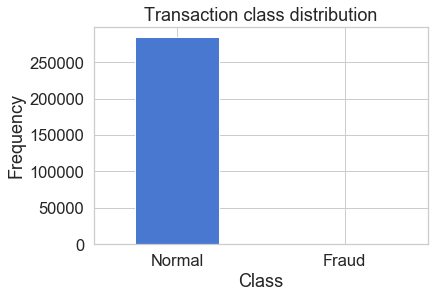

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [6]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [7]:
frauds.shape

(492, 31)

In [8]:
normal.shape

(284315, 31)

In [9]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

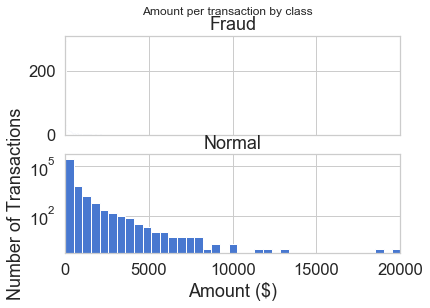

In [11]:
f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins=bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0,20000))
plt.yscale('log')
plt.show()

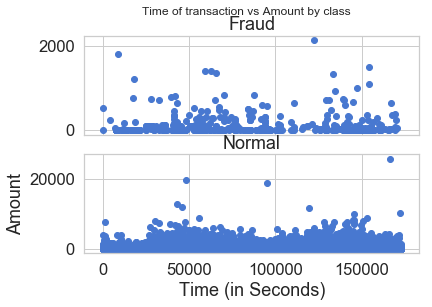

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Autoencoder

In [99]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

In [101]:
data = df.drop(['Time'], axis=1)
norm = data[data.Class == 0]
novel = data[data.Class == 1]
X_train, X_test = train_test_split(norm, test_size=0.4)
X_val, X_test = train_test_split(X_test, test_size=0.5)

In [102]:
X_train.shape

(170589, 30)

In [103]:
X_test.shape

(56863, 30)

In [104]:
X_val.shape

(56863, 30)

In [105]:
novel.shape

(492, 30)

In [106]:
X_test = pd.concat([X_test, novel])

In [107]:
X_test.shape

(57355, 30)

In [108]:
minmax = MinMaxScaler()
X_train['Amount'] = minmax.fit_transform(X_train['Amount'].values.reshape(-1,1))
X_val['Amount'] = minmax.transform(X_val['Amount'].values.reshape(-1,1))
X_test['Amount'] = minmax.transform(X_test['Amount'].values.reshape(-1,1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [109]:
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.drop(['Class'], axis=1)
X_val = X_val.drop(['Class'], axis=1)

X_train = X_train.values
X_val = X_val.values
X_test = X_test.values
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
X_test = torch.from_numpy(X_test).float()

In [110]:
X_train.shape

torch.Size([170589, 29])

In [113]:
y_test.shape

(57355,)

In [114]:
batch_size = 32
trainset = DataLoader(X_train, batch_size = batch_size, shuffle=True)
validset = DataLoader(X_val, batch_size = batch_size, shuffle=True)
testset = DataLoader(X_test, batch_size = batch_size)
testlabel = DataLoader(y_test, batch_size = batch_size)

## h_dim = 10, z_dim = 2

In [115]:
device = torch.device('cpu')
input_dim = 29
h_dim = 10
z_dim = 2
num_epochs = 100
learning_rate = 1e-3

class VAE(nn.Module):
    def __init__(self, input_dim = input_dim, h_dim = h_dim, z_dim = z_dim):
        super(VAE,self).__init__()
        self.fc1 = nn.Linear(input_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, input_dim)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.rand_like(std)
        return mu+eps*std
    def decode(self,z):
        h = F.relu(self.fc4(z))
        return self.fc5(h)
    
    def forward(self,x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var
    

model = VAE().to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [116]:
best_reconst_loss = 999999999999999999
train_loss = []
valid_loss = []
test_loss = []
for epoch in range(num_epochs):
    tmp = 0
    cnt = 0
    for i, x in enumerate(trainset):
        x_reconst, mu, log_var = model(x)
        
        reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
        tmp += reconst_loss.item()
        cnt += 1
        kl_div = -0.5 * torch.sum(1+log_var - mu.pow(2) - log_var.exp())
        
        loss = reconst_loss+kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
#         if (i+1) % 10 == 0:
#             print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
#                  .format(epoch+1, num_epochs, i+1, len(trainset), reconst_loss.item(), kl_div.item()))
    train_loss += [tmp/cnt]
    
    valid_reconst_loss = 0
    cnt = 0
    for j, y in enumerate(validset):
        y_reconst, _, _ = model(y)
        valid_reconst_loss += F.mse_loss(y_reconst, y, size_average=False)
        cnt += 1
    valid_loss += [valid_reconst_loss.item()/cnt]
    if (valid_reconst_loss < best_reconst_loss):
        best_model = model
        best_reconst_loss = valid_reconst_loss
        
    with torch.no_grad():
        test_reconst_loss = 0
        cnt = 0
        for x in testset:
            x_reconst, mu, log_var = best_model(x)
            
            reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
            cnt += 1
            test_reconst_loss += reconst_loss.item()
        test_loss += [test_reconst_loss/cnt]
    print("epoch: ", epoch,"train_loss :", train_loss[epoch], "valid_loss :", valid_loss[epoch], "test_loss :", test_loss[epoch])

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch:  0 train_loss : 705.5728046028682 valid_loss : 632.2644203714125 test_loss : 833.6831041751996
epoch:  1 train_loss : 635.2155344856991 valid_loss : 621.5870849746764 test_loss : 811.1997913162734
epoch:  2 train_loss : 627.6240484824079 valid_loss : 617.1729741136747 test_loss : 809.8807550739856
epoch:  3 train_loss : 622.6072519588953 valid_loss : 612.0251125492402 test_loss : 807.132884019723
epoch:  4 train_loss : 617.6871339379009 valid_loss : 607.7823579065841 test_loss : 803.4157732374763
epoch:  5 train_loss : 612.667269101176 valid_loss : 602.8666994935285 test_loss : 796.1596007041271
epoch:  6 train_loss : 607.3927920628971 valid_loss : 600.2988182329769 test_loss : 787.9807654836626
epoch:  7 train_loss : 601.9582683253391 valid_loss : 593.6797270680922 test_loss : 782.0472046511172
epoch:  8 train_loss : 597.24252929573 valid_loss : 590.4929656724817 test_loss : 1247.2328250031862
epoch:  9 train_loss : 592.8709127568903 valid_loss : 584.5733680360157 test_loss : 8

epoch:  80 train_loss : 549.8836821736951 valid_loss : 552.3457723691615 test_loss : 729.4988116186156
epoch:  81 train_loss : 549.7234977531826 valid_loss : 546.3796426561621 test_loss : 721.5538041752541
epoch:  82 train_loss : 549.8147488781713 valid_loss : 588.3305430500844 test_loss : 781.2892399036346
epoch:  83 train_loss : 549.7544152026014 valid_loss : 545.7207020258863 test_loss : 722.9556960506408
epoch:  84 train_loss : 549.6901961945388 valid_loss : 547.380170230726 test_loss : 718.352788173082
epoch:  85 train_loss : 549.7969215577683 valid_loss : 546.7557329769274 test_loss : 723.0858201953996
epoch:  86 train_loss : 549.5348139218868 valid_loss : 546.2531302757457 test_loss : 721.1645348671755
epoch:  87 train_loss : 549.824122251254 valid_loss : 544.3220666854248 test_loss : 721.5398128443568
epoch:  88 train_loss : 549.6181734908345 valid_loss : 546.0025675295442 test_loss : 725.2795369647697
epoch:  89 train_loss : 549.2698192006092 valid_loss : 546.4914532920653 tes

In [117]:
torch.save(best_model,'model.h5')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [118]:
best_model = torch.load('model.h5')
best_model.eval()

NameError: name 'load_model' is not defined

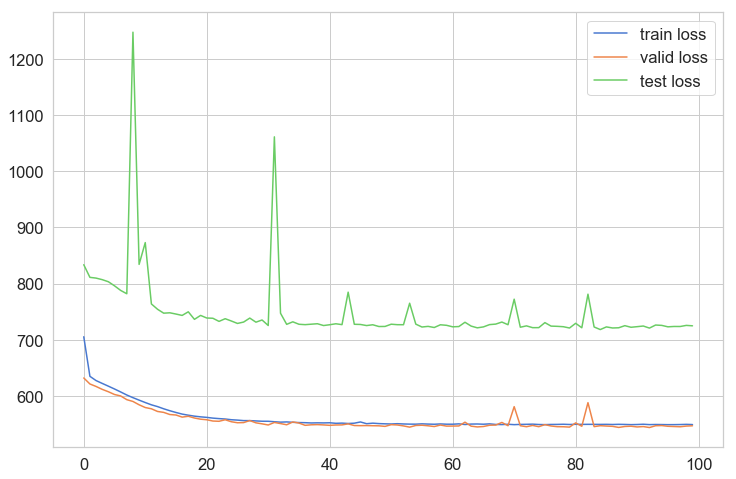

In [119]:
plt.figure(figsize=(12,8))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.plot(test_loss)
plt.legend(['train loss', 'valid loss', 'test loss'])
plt.show()

### Evaluation

In [120]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report, f1_score, precision_recall_fscore_support, average_precision_score

In [121]:
best_model.eval()
y_pred = best_model(X_test)[0] #0은 reconst loss 1은 mu 2는 sigma

In [122]:
y_pred.shape

torch.Size([57355, 29])

In [123]:
mse = np.mean(np.power(X_test.detach().numpy() - y_pred.detach().numpy(), 2), axis=1)

In [124]:
fpr, tpr, thresholds = roc_curve(y_test, mse)
roc_auc = auc(fpr, tpr)
precision, recalls, thre = precision_recall_curve(y_test, mse)
prc_average = average_precision_score(y_test, mse)
prc_auc = auc(recalls, precision)

In [125]:
prc_auc

0.6606426587965964

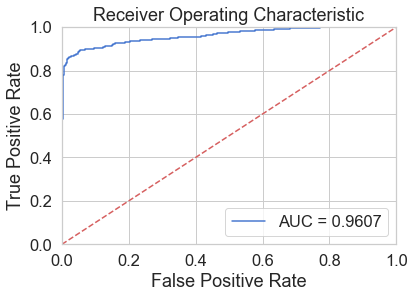

In [126]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

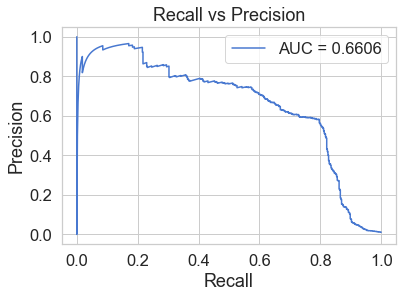

In [127]:
precision, recall, th = precision_recall_curve(y_test, mse)
plt.plot(recall, precision, 'b', label='AUC = %0.4f' % prc_auc)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


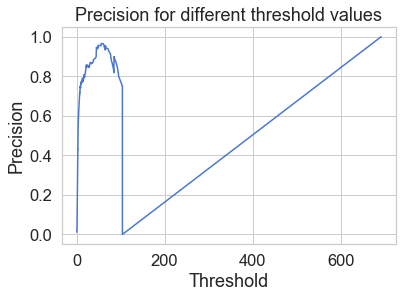

In [128]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

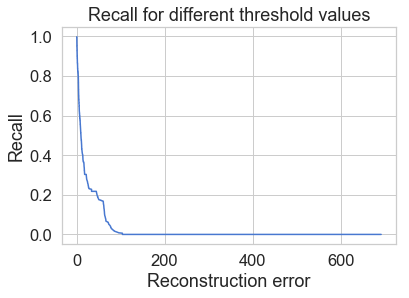

In [129]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

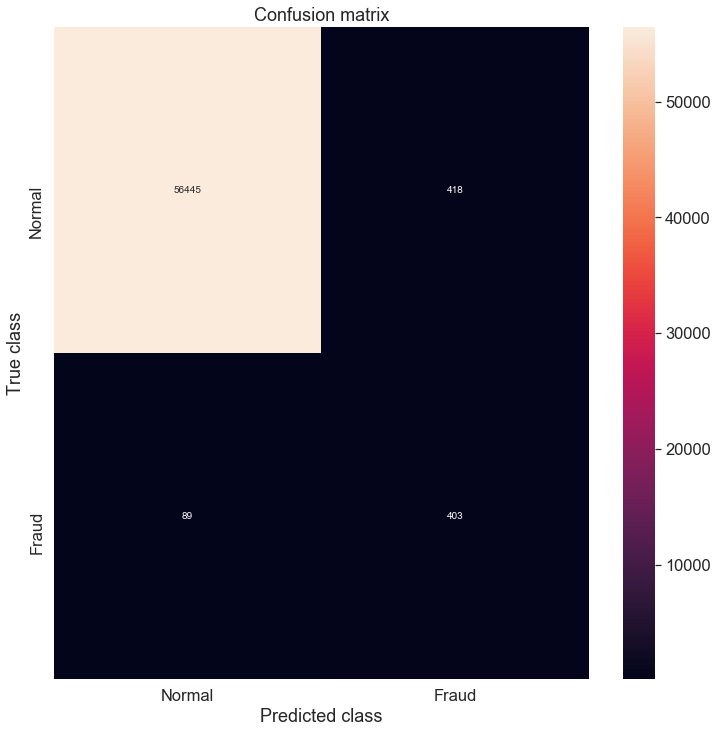

In [130]:
threshold = 3
y_pred = [1 if e > threshold else 0 for e in mse]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## h_dim = 15, 7 z_dim = 2

In [131]:
device = torch.device('cpu')
input_dim = 29
h1_dim = 15
h2_dim = 7
z_dim = 2
num_epochs = 100
learning_rate = 1e-3

class VAE(nn.Module):
    def __init__(self, input_dim = input_dim, h1_dim = h1_dim, h2_dim = h2_dim, z_dim = z_dim):
        super(VAE,self).__init__()
        self.fc1 = nn.Linear(input_dim, h1_dim)
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        self.fc3 = nn.Linear(h2_dim, z_dim)
        self.fc4 = nn.Linear(h2_dim, z_dim)
        self.fc5 = nn.Linear(z_dim, h2_dim)
        self.fc6 = nn.Linear(h2_dim, h1_dim)
        self.fc7 = nn.Linear(h1_dim, input_dim)
        
    def encode(self, x):
        h = F.relu(self.fc2(F.relu(self.fc1(x))))
        return self.fc3(h), self.fc4(h)
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.rand_like(std)
        return mu+eps*std
    def decode(self,z):
        h = F.relu(self.fc6(F.relu(self.fc5(z))))
        return self.fc7(h)
    
    def forward(self,x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var
    

model = VAE().to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [132]:
best_reconst_loss = 999999999999999999
train_loss = []
valid_loss = []
test_loss = []
for epoch in range(num_epochs):
    tmp = 0
    cnt = 0
    for i, x in enumerate(trainset):
        x_reconst, mu, log_var = model(x)
        
        reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
        tmp += reconst_loss.item()
        cnt += 1
        kl_div = -0.5 * torch.sum(1+log_var - mu.pow(2) - log_var.exp())
        
        loss = reconst_loss+kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
#         if (i+1) % 10 == 0:
#             print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
#                  .format(epoch+1, num_epochs, i+1, len(trainset), reconst_loss.item(), kl_div.item()))
    train_loss += [tmp/cnt]
    
    valid_reconst_loss = 0
    cnt = 0
    for j, y in enumerate(validset):
        y_reconst, _, _ = model(y)
        valid_reconst_loss += F.mse_loss(y_reconst, y, size_average=False).item()
        cnt += 1
    valid_loss += [valid_reconst_loss.item()/cnt]
    if (valid_reconst_loss < best_reconst_loss):
        best_model = model
        best_reconst_loss = valid_reconst_loss
        
    with torch.no_grad():
        test_reconst_loss = 0
        cnt = 0
        for x in testset:
            x_reconst, mu, log_var = best_model(x)
            
            reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
            cnt += 1
            test_reconst_loss += reconst_loss.item()
        test_loss += [test_reconst_loss/cnt]
    print("epoch: ", epoch,"train_loss :", train_loss[epoch], "valid_loss :", valid_loss[epoch], "test_loss :", test_loss[epoch])

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch:  0 train_loss : 698.0713227572036 valid_loss : 625.5753376477209 test_loss : 831.5840782084681
epoch:  1 train_loss : 614.3364648913782 valid_loss : 589.5123804164322 test_loss : 787.6689323429548
epoch:  2 train_loss : 584.6556910606246 valid_loss : 568.1239800225098 test_loss : 757.3047400079356
epoch:  3 train_loss : 567.6012263257784 valid_loss : 556.7766249296567 test_loss : 750.8088079857813
epoch:  4 train_loss : 558.4850830352904 valid_loss : 549.9241347777153 test_loss : 742.8046597567471
epoch:  5 train_loss : 552.7528877322702 valid_loss : 545.2134214969049 test_loss : 738.1581098191643
epoch:  6 train_loss : 545.0344422153809 valid_loss : 544.581703714125 test_loss : 740.4669036950337
epoch:  7 train_loss : 536.2838375025004 valid_loss : 529.0641178953292 test_loss : 719.1172688234736
epoch:  8 train_loss : 533.5378208564697 valid_loss : 525.3658553742263 test_loss : 711.8016522009148
epoch:  9 train_loss : 531.5944658035053 valid_loss : 524.5809299380979 test_loss :

epoch:  80 train_loss : 457.453666107401 valid_loss : 457.53056415306696 test_loss : 634.5509925582724
epoch:  81 train_loss : 456.77394939502034 valid_loss : 455.90862408553744 test_loss : 635.3036485236913
epoch:  82 train_loss : 457.0187988968196 valid_loss : 457.60523353967363 test_loss : 635.5300458917656
epoch:  83 train_loss : 456.78073315324355 valid_loss : 457.1208849184018 test_loss : 632.6498247817849
epoch:  84 train_loss : 457.3758545265348 valid_loss : 455.39423888576255 test_loss : 632.5079634709526
epoch:  85 train_loss : 457.40856784182984 valid_loss : 457.07839758019134 test_loss : 638.5434177141248
epoch:  86 train_loss : 457.16815143757657 valid_loss : 454.68609313449633 test_loss : 633.7693223075632
epoch:  87 train_loss : 456.8076234787809 valid_loss : 456.28541783905456 test_loss : 634.2098186129109
epoch:  88 train_loss : 456.98244833959643 valid_loss : 460.11406162070904 test_loss : 638.4382855765858
epoch:  89 train_loss : 456.5381982474541 valid_loss : 456.09

In [133]:
torch.save(best_model,'model.h6')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


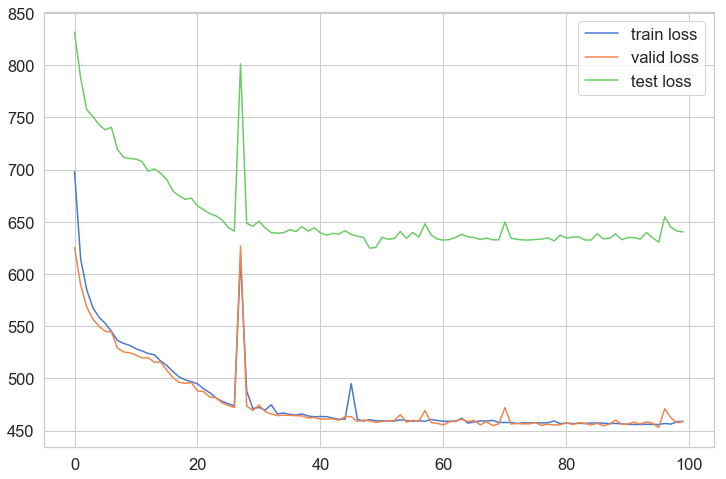

In [134]:
plt.figure(figsize=(12,8))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.plot(test_loss)
plt.legend(['train loss', 'valid loss', 'test loss'])
plt.show()

### Evaluation

In [135]:
best_model.eval()
y_pred = best_model(X_test)[0] #0은 reconst loss 1은 mu 2는 sigma

In [136]:
mse = np.mean(np.power(X_test.detach().numpy() - y_pred.detach().numpy(), 2), axis=1)
fpr, tpr, thresholds = roc_curve(y_test, mse)
roc_auc = auc(fpr, tpr)
precision, recalls, thre = precision_recall_curve(y_test, mse)
prc_average = average_precision_score(y_test, mse)
prc_auc = auc(recalls, precision)

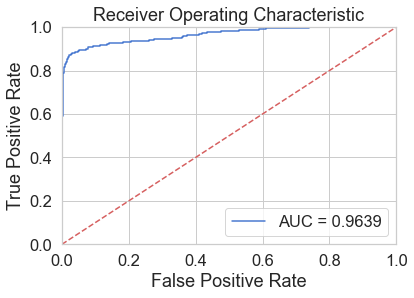

In [137]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

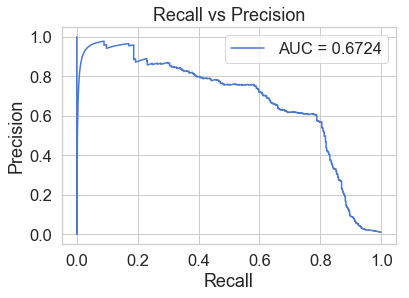

In [138]:
precision, recall, th = precision_recall_curve(y_test, mse)
plt.plot(recall, precision, 'b', label='AUC = %0.4f' % prc_auc)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


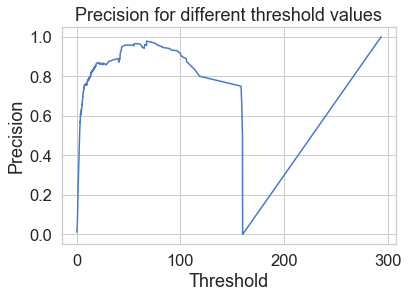

In [139]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

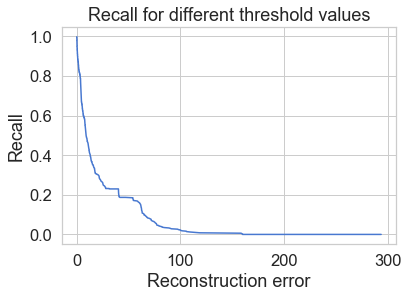

In [140]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

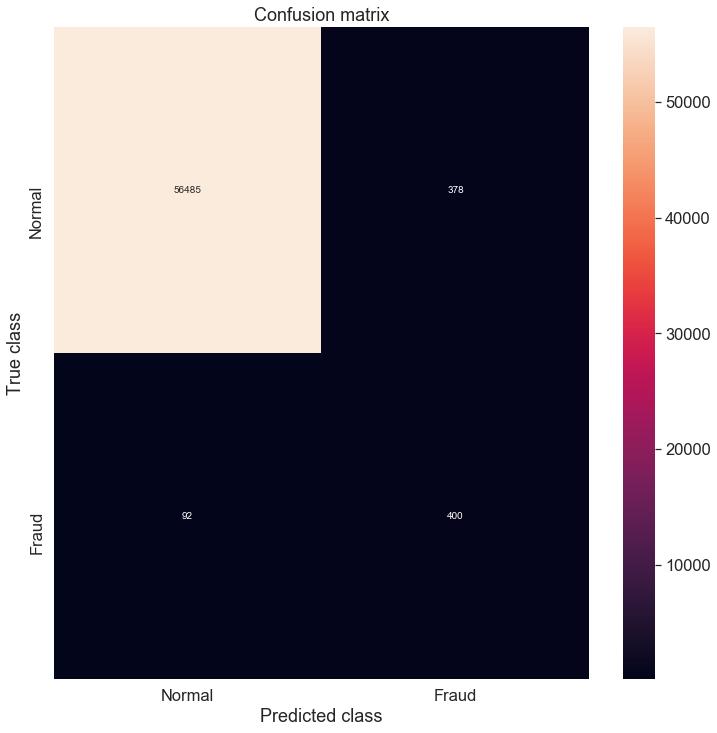

In [141]:
threshold = 3
y_pred = [1 if e > threshold else 0 for e in mse]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## h_dim 15, 7, z_dim 5

In [143]:
device = torch.device('cpu')
input_dim = 29
h1_dim = 17
h2_dim = 9
z_dim = 5
num_epochs = 100
learning_rate = 1e-3

class VAE(nn.Module):
    def __init__(self, input_dim = input_dim, h1_dim = h1_dim, h2_dim = h2_dim, z_dim = z_dim):
        super(VAE,self).__init__()
        self.fc1 = nn.Linear(input_dim, h1_dim)
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        self.fc3 = nn.Linear(h2_dim, z_dim)
        self.fc4 = nn.Linear(h2_dim, z_dim)
        self.fc5 = nn.Linear(z_dim, h2_dim)
        self.fc6 = nn.Linear(h2_dim, h1_dim)
        self.fc7 = nn.Linear(h1_dim, input_dim)
        
    def encode(self, x):
        h = F.relu(self.fc2(F.relu(self.fc1(x))))
        return self.fc3(h), self.fc4(h)
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.rand_like(std)
        return mu+eps*std
    def decode(self,z):
        h = F.relu(self.fc6(F.relu(self.fc5(z))))
        return self.fc7(h)
    
    def forward(self,x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var
    

model = VAE().to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [145]:
best_reconst_loss = 999999999999999999
train_loss = []
valid_loss = []
test_loss = []
for epoch in range(num_epochs):
    tmp = 0
    cnt = 0
    for i, x in enumerate(trainset):
        x_reconst, mu, log_var = model(x)
        
        reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
        tmp += reconst_loss.item()
        cnt += 1
        kl_div = -0.5 * torch.sum(1+log_var - mu.pow(2) - log_var.exp())
        
        loss = reconst_loss+kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
#         if (i+1) % 10 == 0:
#             print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
#                  .format(epoch+1, num_epochs, i+1, len(trainset), reconst_loss.item(), kl_div.item()))
    train_loss += [tmp/cnt]
    
    valid_reconst_loss = 0
    cnt = 0
    for j, y in enumerate(validset):
        y_reconst, _, _ = model(y)
        valid_reconst_loss += F.mse_loss(y_reconst, y, size_average=False)
        cnt += 1
    valid_loss += [valid_reconst_loss.item()/cnt]
    if (valid_reconst_loss < best_reconst_loss):
        best_model = model
        best_reconst_loss = valid_reconst_loss
        
    with torch.no_grad():
        test_reconst_loss = 0
        cnt = 0
        for x in testset:
            x_reconst, mu, log_var = best_model(x)
            
            reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
            cnt += 1
            test_reconst_loss += reconst_loss.item()
        test_loss += [test_reconst_loss/cnt]
    print("epoch: ", epoch,"train_loss :", train_loss[epoch], "valid_loss :", valid_loss[epoch], "test_loss :", test_loss[epoch])

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch:  0 train_loss : 452.00276293707174 valid_loss : 418.87260832864376 test_loss : 604.8639352163389
epoch:  1 train_loss : 404.49393446390457 valid_loss : 389.229600450197 test_loss : 561.3121123263375
epoch:  2 train_loss : 385.0402897892202 valid_loss : 376.5135410804727 test_loss : 542.5611991563192
epoch:  3 train_loss : 376.9954856596349 valid_loss : 370.39290236353406 test_loss : 541.3621756813743
epoch:  4 train_loss : 371.1781575623875 valid_loss : 370.33279403489024 test_loss : 537.7390332027846
epoch:  5 train_loss : 366.0623771568732 valid_loss : 363.5645751266179 test_loss : 541.2333754259186
epoch:  6 train_loss : 362.15855295799884 valid_loss : 356.74148846370286 test_loss : 526.3668936512953
epoch:  7 train_loss : 358.1768049942443 valid_loss : 352.5300365785031 test_loss : 516.7302405149393
epoch:  8 train_loss : 354.1611356690506 valid_loss : 351.4778418683174 test_loss : 519.693569900334
epoch:  9 train_loss : 351.9112203265641 valid_loss : 348.73294175576814 test

epoch:  79 train_loss : 314.5055440381418 valid_loss : 311.2929445694992 test_loss : 469.85755807224496
epoch:  80 train_loss : 314.4586490565987 valid_loss : 313.2431415306697 test_loss : 474.73893715666446
epoch:  81 train_loss : 314.01008815189346 valid_loss : 315.0378446820484 test_loss : 471.44243777988345
epoch:  82 train_loss : 314.02845563800895 valid_loss : 312.069815700619 test_loss : 471.2495519549768
epoch:  83 train_loss : 313.9765631010778 valid_loss : 310.9313449634215 test_loss : 470.44487562035954
epoch:  84 train_loss : 314.2934179382954 valid_loss : 311.17125070343275 test_loss : 474.8181026477888
epoch:  85 train_loss : 314.05553147618843 valid_loss : 312.27848902644905 test_loss : 473.93160985211586
epoch:  86 train_loss : 314.2250385388181 valid_loss : 311.3476012943163 test_loss : 473.58320093447446
epoch:  87 train_loss : 314.08140833591165 valid_loss : 312.9179797411367 test_loss : 470.792144196697
epoch:  88 train_loss : 314.07122413751176 valid_loss : 314.224

In [146]:
torch.save(best_model,'model.h7')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


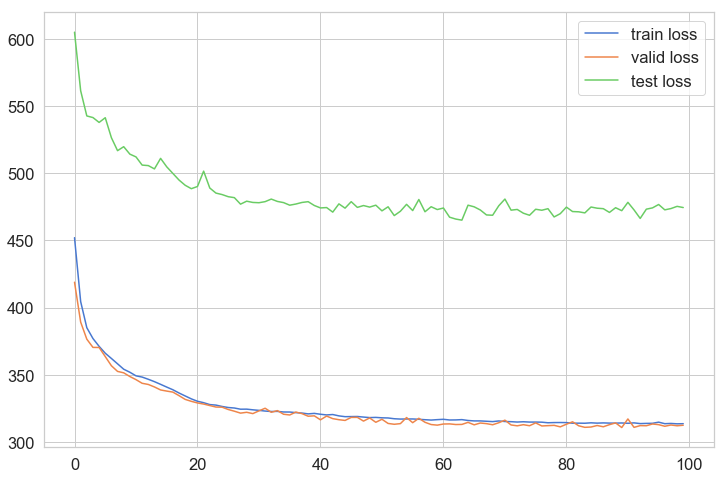

In [147]:
plt.figure(figsize=(12,8))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.plot(test_loss)
plt.legend(['train loss', 'valid loss', 'test loss'])
plt.show()

### Evaluation

In [148]:
best_model.eval()
y_pred = best_model(X_test)[0] #0은 reconst loss 1은 mu 2는 sigma

In [149]:
mse = np.mean(np.power(X_test.detach().numpy() - y_pred.detach().numpy(), 2), axis=1)
fpr, tpr, thresholds = roc_curve(y_test, mse)
roc_auc = auc(fpr, tpr)
precision, recalls, thre = precision_recall_curve(y_test, mse)
prc_average = average_precision_score(y_test, mse)
prc_auc = auc(recalls, precision)

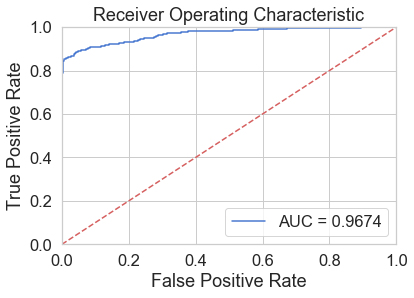

In [150]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

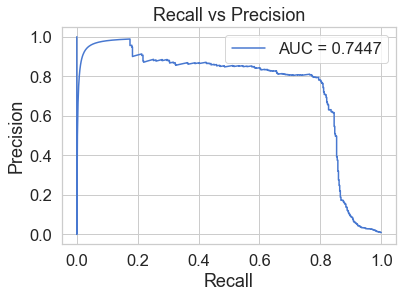

In [151]:
precision, recall, th = precision_recall_curve(y_test, mse)
plt.plot(recall, precision, 'b', label='AUC = %0.4f' % prc_auc)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


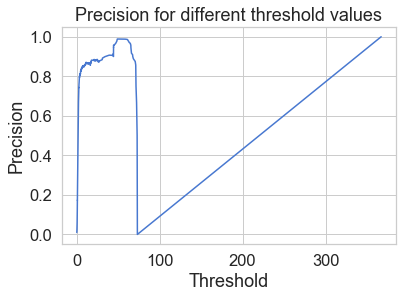

In [152]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

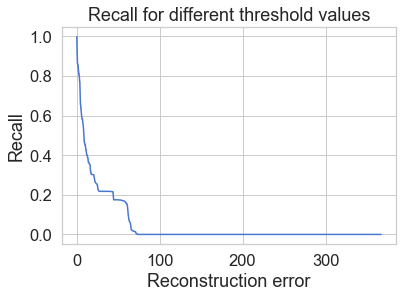

In [153]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

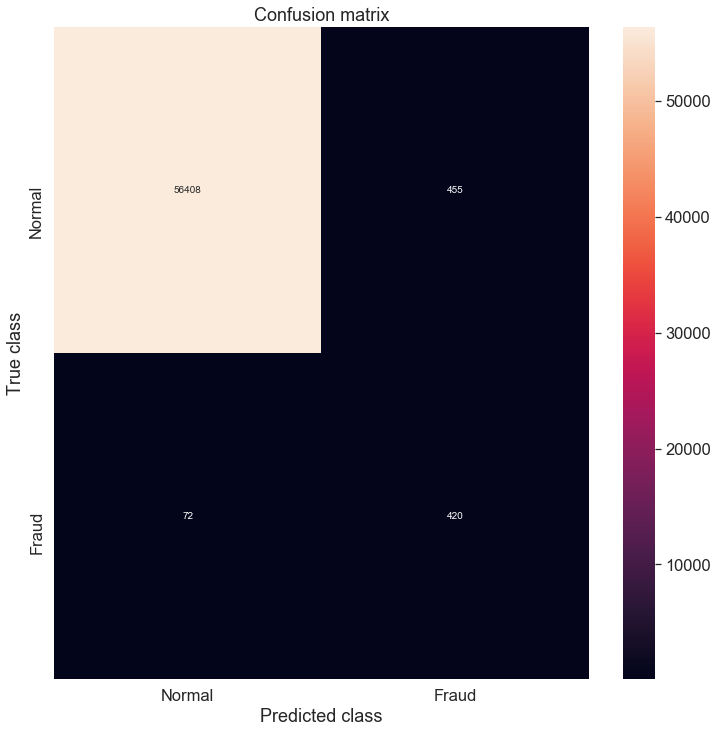

In [156]:
threshold = 1.5
y_pred = [1 if e > threshold else 0 for e in mse]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## h_dim 20, 15, z_dim 10 

In [157]:
device = torch.device('cpu')
input_dim = 29
h1_dim = 20
h2_dim = 15
z_dim = 10
num_epochs = 100
learning_rate = 1e-3

class VAE(nn.Module):
    def __init__(self, input_dim = input_dim, h1_dim = h1_dim, h2_dim = h2_dim, z_dim = z_dim):
        super(VAE,self).__init__()
        self.fc1 = nn.Linear(input_dim, h1_dim)
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        self.fc3 = nn.Linear(h2_dim, z_dim)
        self.fc4 = nn.Linear(h2_dim, z_dim)
        self.fc5 = nn.Linear(z_dim, h2_dim)
        self.fc6 = nn.Linear(h2_dim, h1_dim)
        self.fc7 = nn.Linear(h1_dim, input_dim)
        
    def encode(self, x):
        h = F.relu(self.fc2(F.relu(self.fc1(x))))
        return self.fc3(h), self.fc4(h)
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.rand_like(std)
        return mu+eps*std
    def decode(self,z):
        h = F.relu(self.fc6(F.relu(self.fc5(z))))
        return self.fc7(h)
    
    def forward(self,x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var
    

model = VAE().to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [158]:
best_reconst_loss = 999999999999999999
train_loss = []
valid_loss = []
test_loss = []
for epoch in range(num_epochs):
    tmp = 0
    cnt = 0
    for i, x in enumerate(trainset):
        x_reconst, mu, log_var = model(x)
        
        reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
        tmp += reconst_loss.item()
        cnt += 1
        kl_div = -0.5 * torch.sum(1+log_var - mu.pow(2) - log_var.exp())
        
        loss = reconst_loss+kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
#         if (i+1) % 10 == 0:
#             print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
#                  .format(epoch+1, num_epochs, i+1, len(trainset), reconst_loss.item(), kl_div.item()))
    train_loss += [tmp/cnt]
    
    valid_reconst_loss = 0
    cnt = 0
    for j, y in enumerate(validset):
        y_reconst, _, _ = model(y)
        valid_reconst_loss += F.mse_loss(y_reconst, y, size_average=False)
        cnt += 1
    valid_loss += [valid_reconst_loss.item()/cnt]
    if (valid_reconst_loss < best_reconst_loss):
        best_model = model
        best_reconst_loss = valid_reconst_loss
        
    with torch.no_grad():
        test_reconst_loss = 0
        cnt = 0
        for x in testset:
            x_reconst, mu, log_var = best_model(x)
            
            reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
            cnt += 1
            test_reconst_loss += reconst_loss.item()
        test_loss += [test_reconst_loss/cnt]
    print("epoch: ", epoch,"train_loss :", train_loss[epoch], "valid_loss :", valid_loss[epoch], "test_loss :", test_loss[epoch])

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch:  0 train_loss : 535.939490194326 valid_loss : 413.0182189082724 test_loss : 595.1989467895304
epoch:  1 train_loss : 377.2693042658525 valid_loss : 321.9761184580754 test_loss : 494.066893807883
epoch:  2 train_loss : 310.64138850332137 valid_loss : 300.5303179516038 test_loss : 452.88821218802286
epoch:  3 train_loss : 292.5283122695067 valid_loss : 284.6227841868317 test_loss : 434.5978564609713
epoch:  4 train_loss : 266.843910922836 valid_loss : 250.4987865785031 test_loss : 397.50434432106846
epoch:  5 train_loss : 244.98016519140424 valid_loss : 241.58574845244794 test_loss : 387.8477712228055
epoch:  6 train_loss : 236.71019125047354 valid_loss : 241.44599395047834 test_loss : 384.93551317460697
epoch:  7 train_loss : 231.8310317721248 valid_loss : 227.4075161789533 test_loss : 371.10703437154143
epoch:  8 train_loss : 227.9897458848039 valid_loss : 225.15519485087225 test_loss : 369.65729436326546
epoch:  9 train_loss : 224.10030806496184 valid_loss : 219.73572031513788 

epoch:  79 train_loss : 183.0976899905 valid_loss : 182.68635692177827 test_loss : 325.0949939402268
epoch:  80 train_loss : 182.79759577957066 valid_loss : 179.79825548677547 test_loss : 324.3096922423942
epoch:  81 train_loss : 182.89281836863734 valid_loss : 179.82990996060778 test_loss : 324.90339899781156
epoch:  82 train_loss : 182.6715564158906 valid_loss : 181.50703432751828 test_loss : 327.9064573127334
epoch:  83 train_loss : 183.11789030448242 valid_loss : 182.16541221159258 test_loss : 327.9461345768347
epoch:  84 train_loss : 182.75030489814057 valid_loss : 181.31040728756332 test_loss : 323.5289690237902
epoch:  85 train_loss : 182.77248154445027 valid_loss : 181.41391741699493 test_loss : 321.9814647838382
epoch:  86 train_loss : 182.59813773620868 valid_loss : 182.67503165447383 test_loss : 325.73397094845706
epoch:  87 train_loss : 182.68346657911312 valid_loss : 181.00348199212155 test_loss : 317.300731529155
epoch:  88 train_loss : 182.59502139115642 valid_loss : 181

In [159]:
torch.save(best_model,'model.h8')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


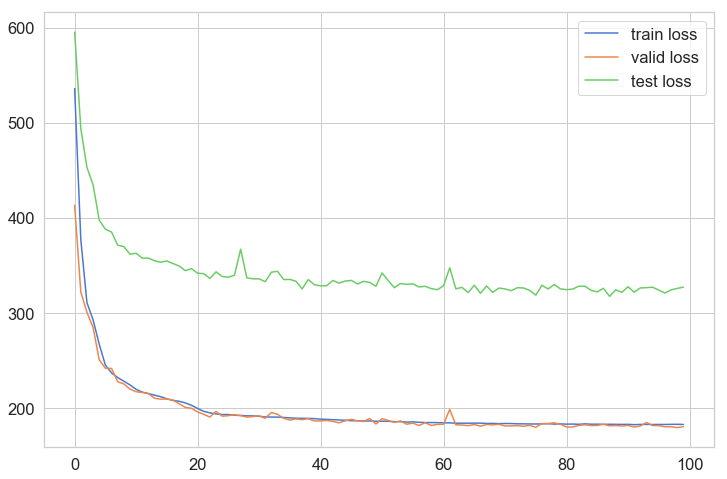

In [160]:
plt.figure(figsize=(12,8))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.plot(test_loss)
plt.legend(['train loss', 'valid loss', 'test loss'])
plt.show()

### Evaluation

In [161]:
best_model.eval()
y_pred = best_model(X_test)[0] #0은 reconst loss 1은 mu 2는 sigma

In [162]:
mse = np.mean(np.power(X_test.detach().numpy() - y_pred.detach().numpy(), 2), axis=1)
fpr, tpr, thresholds = roc_curve(y_test, mse)
roc_auc = auc(fpr, tpr)
precision, recalls, thre = precision_recall_curve(y_test, mse)
prc_average = average_precision_score(y_test, mse)
prc_auc = auc(recalls, precision)

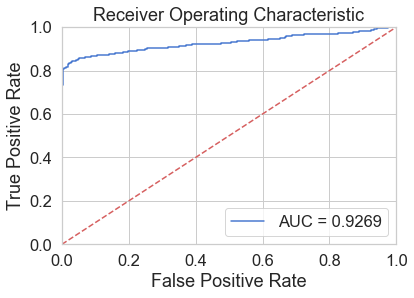

In [163]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

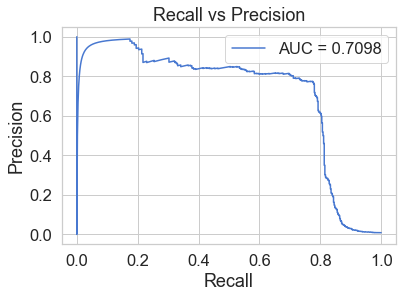

In [164]:
precision, recall, th = precision_recall_curve(y_test, mse)
plt.plot(recall, precision, 'b', label='AUC = %0.4f' % prc_auc)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


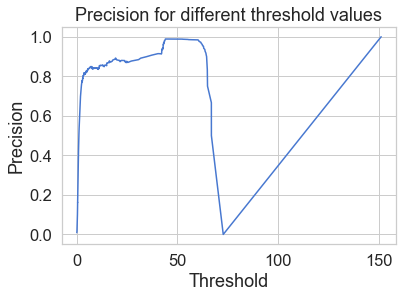

In [165]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

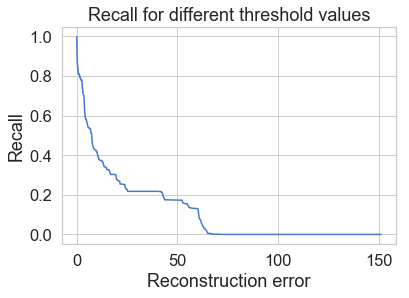

In [166]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

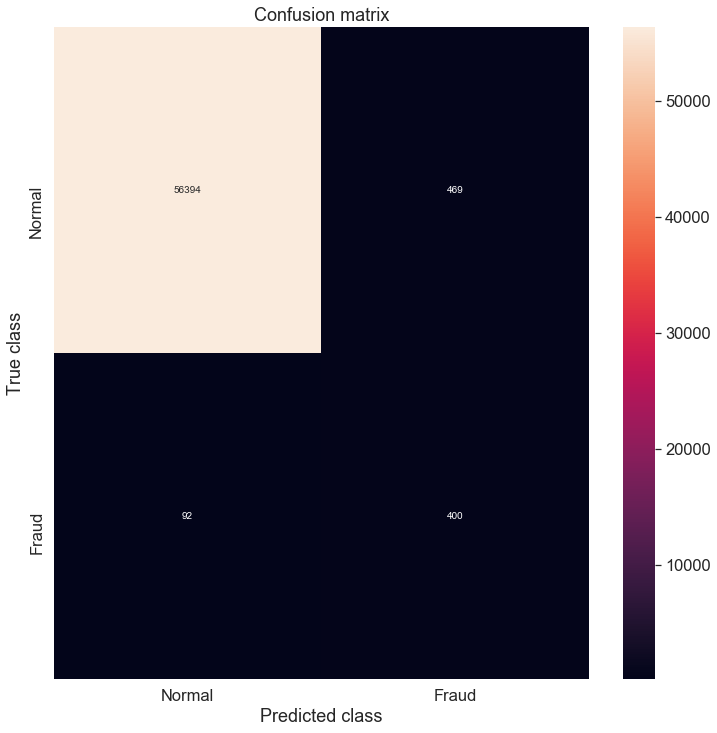

In [167]:
threshold = 1
y_pred = [1 if e > threshold else 0 for e in mse]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()